In [0]:
import os
os.chdir('/content/drive/My Drive/FACE RECOGNITION TRAINING')
os.listdir('/content/drive/My Drive/FACE RECOGNITION TRAINING')
# os.mkdir('training_images')

['vgg_face_weights.h5',
 'facenet_weights.h5',
 'inception_resnet_v1.py',
 'training',
 '__pycache__',
 'temp2',
 'known_faces',
 'test_images',
 'training_images',
 'test_images (1)',
 'siamese_net_bce.h5',
 'validation_images',
 'siamese_net_bce2.h5',
 'unknown_faces']

In [0]:
!pip install face_recognition

In [0]:
from keras.regularizers import l2
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.initializers import RandomNormal

################
from keras import layers
from keras.layers import Input, Layer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras import backend as K

In [0]:
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

In [0]:
def create_model(input_shape):
    X_input = Input(input_shape)

    X = Conv2D(32, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    # X = BatchNormalization(axis = -1, name = 'bn_conv1')(X)
    X = Conv2D(32, (3, 3), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = -1, name = 'bn_conv2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)
    
    X = Conv2D(64, (3, 3), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis = -1, name = 'bn_conv3')(X)
    X = Conv2D(64, (3, 3), name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = 'bn_conv4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)
    
    X = Conv2D(128, (3, 3), name = 'conv5', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = 'bn_conv5')(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    X = MaxPooling2D((3, 3))(X)

    X = Conv2D(256, (1, 1), name = 'conv6', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = 'bn_conv6')(X)
    X = Activation('relu')(X)
    
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1', kernel_initializer = glorot_uniform(seed=0))(X)
    
    return Model(inputs=[X_input], outputs=X) 

In [0]:
IMAGE_SIZE = 96
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

convnet = create_model(input_shape)

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

In [0]:
convnet.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 94, 94, 32)        320       
_________________________________________________________________
bn_conv2 (BatchNormalization (None, 94, 94, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 27, 27, 64)        3692

In [0]:
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

In [0]:
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=RandomNormal(mean=0.5, stddev=1e-2))(L1_distance)

In [0]:
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
optimizer = Adam(0.00006)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:
import os
import cv2
import numpy as np
FRAME_THICKNESS = 3
FONT_THICKNESS = 2
TRAINING_FACES_DIR = "training"

def zscore(x):
  mean = np.mean(x)
  std = np.std(x)
  std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
  y = np.multiply(np.subtract(x, mean), 1 / std_adj)
  return y

In [0]:
print("loading faces")

faces = os.listdir(TRAINING_FACES_DIR)
training_images = {}
for name in os.listdir(TRAINING_FACES_DIR):
	temp = []
	for filename in os.listdir(f"{TRAINING_FACES_DIR}/{name}"):
		image = cv2.imread(f"{TRAINING_FACES_DIR}/{name}/{filename}")
		image = cv2.resize(image, input_shape[:-1])
		image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #cv2.COLOR_RGB2BGR
		image = np.expand_dims(image, axis=-1)
		temp.append(zscore(image))
		# temp.append(np.around(image/255, decimals=5))
	training_images[name] = np.array(temp)

loading faces


In [0]:
print("loading validation faces")
VALIDATION_FACES_DIR = "test_images (1)"
validation_faces = os.listdir(VALIDATION_FACES_DIR)
val_images = {}
for name in os.listdir(VALIDATION_FACES_DIR):
	temp = []
	for filename in os.listdir(f"{VALIDATION_FACES_DIR}/{name}"):
		image = cv2.imread(f"{VALIDATION_FACES_DIR}/{name}/{filename}")
		image = cv2.resize(image, input_shape[:-1])
		image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #cv2.COLOR_RGB2BGR
		image = np.expand_dims(image, axis=-1)
		temp.append(zscore(image))
		# temp.append(np.around(image/255, decimals=5))
	val_images[name] = np.array(temp)

loading validation faces


In [0]:
def pairs_generator(batch_size):
    y_val = np.zeros((batch_size, 1))
    positives = np.zeros((batch_size, input_shape[0], input_shape[1], input_shape[2]))
    negatives = np.zeros((batch_size, input_shape[0], input_shape[1], input_shape[2]))
    while True:
      i = 0
      for i in range(batch_size//2):
        positiveFace = faces[np.random.randint(len(faces))]
        negativeFace = faces[np.random.randint(len(faces))]
        while positiveFace == negativeFace:
          negativeFace = faces[np.random.randint(len(faces))]

        positives[i] =  training_images[positiveFace][np.random.randint(len(training_images[positiveFace]))]
        # plt.imshow(positives[i])
        # plt.show()
        negatives[i] = training_images[negativeFace][np.random.randint(len(training_images[negativeFace]))]
        # plt.imshow(negatives[i])
        # plt.show()
        y_val[i] = 0

      for i in range(i, batch_size):
        positiveFace = faces[np.random.randint(len(faces))]
        negativeFace = faces[np.random.randint(len(faces))]
        while positiveFace != negativeFace:
              negativeFace = faces[np.random.randint(len(faces))]

        positives[i] =  training_images[positiveFace][np.random.randint(len(training_images[positiveFace]))]
        # plt.imshow(positives[i])
        # plt.show()
        negatives[i] = training_images[negativeFace][np.random.randint(len(training_images[negativeFace]))]
        # plt.imshow(negatives[i])
        # plt.show()
        y_val[i] = 1

        yield ([positives, negatives], y_val)

In [0]:
def validation_set(n = 180):

  y_val = np.zeros((n, 1))
  positives = np.zeros((n, input_shape[0], input_shape[1], input_shape[2]))
  negatives = np.zeros((n, input_shape[0], input_shape[1], input_shape[2]))
  i = 0
  for i in range(n//2):
    positiveFace = faces[np.random.randint(len(faces))]
    negativeFace = faces[np.random.randint(len(faces))]
    while positiveFace == negativeFace:
      negativeFace = faces[np.random.randint(len(faces))]

    val_f_count[positiveFace] += 1
    val_f_count[negativeFace] += 1
    positives[i] =  val_images[positiveFace][np.random.randint(len(val_images[positiveFace]))]
    # plt.imshow(positives[i])
    # plt.show()
    negatives[i] = val_images[negativeFace][np.random.randint(len(val_images[negativeFace]))]
    # plt.imshow(negatives[i])
    # plt.show()
    y_val[i] = 0

  for i in range(i, n):
    positiveFace = faces[np.random.randint(len(faces))]
    negativeFace = faces[np.random.randint(len(faces))]
    while positiveFace != negativeFace:
          negativeFace = faces[np.random.randint(len(faces))]

    val_f_count[positiveFace] += 1
    positives[i] =  val_images[positiveFace][np.random.randint(len(val_images[positiveFace]))]
    # plt.imshow(positives[i])
    # plt.show()
    negatives[i] = val_images[negativeFace][np.random.randint(len(val_images[negativeFace]))]
    # plt.imshow(negatives[i])
    # plt.show()
    y_val[i] = 1

  return ([positives, negatives], y_val)

In [0]:
val_f_count = {}
for f in faces:
  val_f_count[f] = 0
val = validation_set()

In [0]:
for f in val_f_count.keys():
  print(f, val_f_count[f])

penny 42
howard 30
sheldon 42
raj 44
lenord 36
bernadette 44
amy 33


In [0]:
x_val, y_val = val

In [0]:
generator = pairs_generator(batch_size=300)
history = siamese_net.fit(generator,
          epochs=100,
          steps_per_epoch=50,
          validation_data=val)

Epoch 1/100
50/50 [==============================] - 11s 211ms/step - loss: 0.6176 - accuracy: 0.4873 - val_loss: 0.7213 - val_accuracy: 0.5056
Epoch 2/100
50/50 [==============================] - 9s 185ms/step - loss: 0.3982 - accuracy: 0.8285 - val_loss: 0.7315 - val_accuracy: 0.4944
Epoch 3/100
50/50 [==============================] - 9s 185ms/step - loss: 0.2778 - accuracy: 0.9506 - val_loss: 0.6993 - val_accuracy: 0.5444
Epoch 4/100
50/50 [==============================] - 9s 186ms/step - loss: 0.2259 - accuracy: 0.9661 - val_loss: 0.7012 - val_accuracy: 0.6222
Epoch 5/100
50/50 [==============================] - 9s 185ms/step - loss: 0.1311 - accuracy: 0.9857 - val_loss: 0.6704 - val_accuracy: 0.6389
Epoch 6/100
50/50 [==============================] - 9s 185ms/step - loss: 0.1350 - accuracy: 0.9708 - val_loss: 0.7001 - val_accuracy: 0.6333
Epoch 7/100
50/50 [==============================] - 9s 184ms/step - loss: 0.1466 - accuracy: 0.9797 - val_loss: 0.5746 - val_accuracy: 0.711

In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

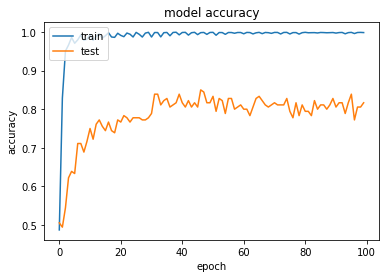

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

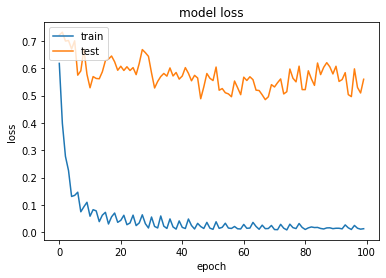

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
generator = pairs_generator(batch_size=300)
history2 = siamese_net.fit(generator,
          epochs=50,
          steps_per_epoch=50,
          validation_data=val)

Epoch 1/50
50/50 [==============================] - 9s 185ms/step - loss: 0.1289 - accuracy: 0.9159 - val_loss: 0.6644 - val_accuracy: 0.7889
Epoch 2/50
50/50 [==============================] - 9s 185ms/step - loss: 0.0094 - accuracy: 0.9993 - val_loss: 0.6232 - val_accuracy: 0.7944
Epoch 3/50
50/50 [==============================] - 9s 185ms/step - loss: 0.0112 - accuracy: 0.9986 - val_loss: 0.6199 - val_accuracy: 0.8056
Epoch 4/50
50/50 [==============================] - 9s 185ms/step - loss: 0.0151 - accuracy: 0.9989 - val_loss: 0.5774 - val_accuracy: 0.8167
Epoch 5/50
50/50 [==============================] - 9s 185ms/step - loss: 0.0176 - accuracy: 0.9986 - val_loss: 0.5470 - val_accuracy: 0.8278
Epoch 6/50
50/50 [==============================] - 9s 186ms/step - loss: 0.0117 - accuracy: 0.9981 - val_loss: 0.6459 - val_accuracy: 0.7944
Epoch 7/50
50/50 [==============================] - 9s 186ms/step - loss: 0.0178 - accuracy: 0.9983 - val_loss: 0.6281 - val_accuracy: 0.7778
Epoch 

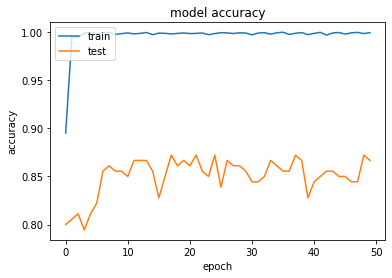

In [0]:

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

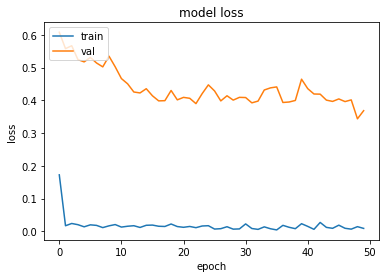

In [0]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
convnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 94, 94, 32)        320       
_________________________________________________________________
bn_conv2 (BatchNormalization (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 27, 27, 64)        3692

In [0]:
#here model_8 is convnet() model
siamese_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256)          426944      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256)          0           model_1[1][0]              

In [0]:
convnet.save("/content/drive/My Drive/FACE RECOGNITION TRAINING/siamese_net_bce2.h5")

In [0]:
convnet.save("/content/drive/My Drive/FACE RECOGNITION TRAINING/training_images/siamese_net_bce2.h5")

In [0]:
IMAGE_SIZE

96

In [0]:
import face_recognition
KNOWN_FACES_DIR = "known_faces"
MODEL = "hog" #cnn

print("loading known faces")
known_faces = []
known_names = []

for name in os.listdir(KNOWN_FACES_DIR):
	for filename in os.listdir(f"{KNOWN_FACES_DIR}/{name}"):
		image = face_recognition.load_image_file(f"{KNOWN_FACES_DIR}/{name}/{filename}")
		face_locations = face_recognition.face_locations(image, model=MODEL)
		for top, right, bottom, left in face_locations:
			image = cv2.resize(np.array(image[top:bottom ,left:right]),(IMAGE_SIZE, IMAGE_SIZE))
			image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
			image = np.expand_dims(image, axis=0)
			image = np.expand_dims(image, axis=-1)
			encoding = convnet.predict(zscore(image))		
		known_faces.append(encoding)
		known_names.append(name)

loading known faces


In [0]:
def testing():
	print('testing')
	positive = 0
	negetive = 0
	test_dir = os.listdir('test_images (1)')
	for name in test_dir:
		test_imgs = os.listdir(f'test_images (1)/{name}')
		for test_img in test_imgs:
			image = cv2.imread(f'test_images (1)/{name}/{test_img}')
			image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
			image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
			image = np.expand_dims(image, axis=0)
			image = np.expand_dims(image, axis=-1)
			image = zscore(image)
			encoding = convnet.predict(image)
			results = [np.sqrt(np.sum(np.square(known_faces[i]-encoding))) for i in range(len(known_faces))]
			match = known_names[results.index(min(results))]
			if(match == name):
				positive += 1
			else:
				negetive += 1
			print(f'{name}/{test_img}',match, min(results))
	print('accuracy :',positive/(positive+negetive))

In [0]:
testing()

testing
sheldon/2.jpg sheldon 11.666353
sheldon/10.jpg sheldon 11.492725
sheldon/9.jpg sheldon 16.3361
sheldon/5.jpg sheldon 9.392118
sheldon/8.jpg sheldon 11.604162
sheldon/6.jpg sheldon 11.462575
sheldon/7.jpg sheldon 13.061398
sheldon/4.jpg sheldon 12.07792
sheldon/1.jpg sheldon 12.476007
sheldon/111.jpg raj 10.833333
sheldon/668.jpg sheldon 11.752374
sheldon/47.jpg sheldon 10.379789
sheldon/109.jpg sheldon 10.782572
sheldon/121.jpg raj 8.869315
sheldon/161.jpg sheldon 10.292287
sheldon/124.jpg sheldon 13.086311
sheldon/126.jpg sheldon 10.527906
sheldon/127.jpg sheldon 12.534506
penny/23.jpg penny 10.884941
penny/21.jpg penny 10.706554
penny/22.jpg penny 12.378379
penny/25.jpg sheldon 13.000957
penny/27.jpg sheldon 12.041898
penny/24.jpg penny 12.821279
penny/26.jpg penny 11.766118
penny/28.jpg penny 10.232754
penny/29.jpg sheldon 12.210449
penny/30.jpg penny 11.454109
penny/penny.jpg penny 10.680418
penny/755.jpg penny 9.999925
penny/206.jpg penny 11.567129
penny/269.jpg penny 11.6

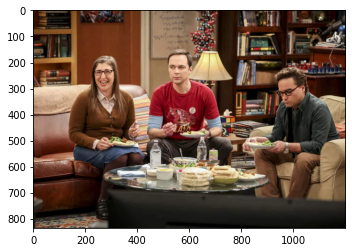

Match found: amy,8.859947204589844
Match found: sheldon,10.095756530761719


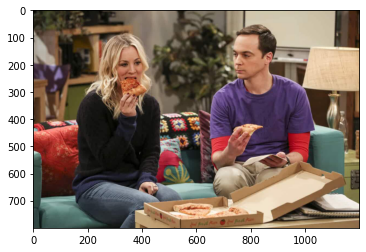

Match found: penny,10.065347671508789
Match found: sheldon,12.96127986907959


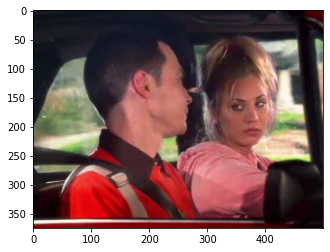

Match found: raj,10.860349655151367


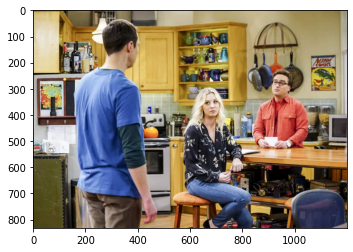

Match found: penny,7.934430122375488
Match found: lenord,9.573050498962402


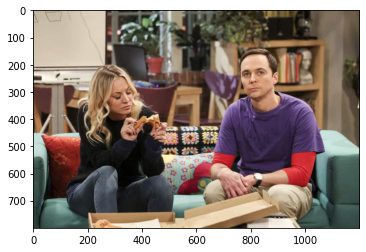

Match found: sheldon,12.424015045166016
Match found: penny,12.730978012084961


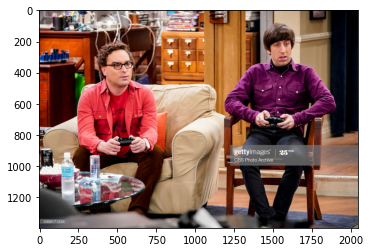

Match found: lenord,11.630651473999023
Match found: howard,6.642768383026123


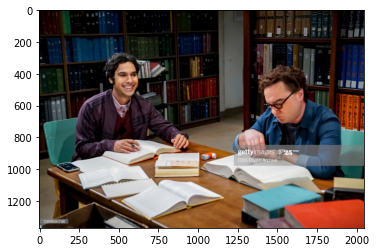

Match found: raj,7.974668979644775


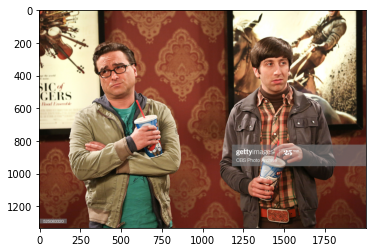

Match found: howard,6.286609172821045
Match found: lenord,8.683958053588867


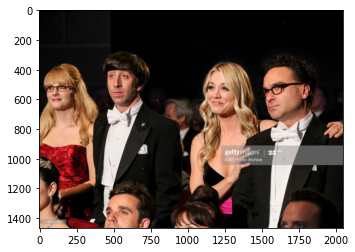

Match found: penny,5.781337738037109
Match found: raj,11.007771492004395
Match found: lenord,11.399139404296875
Match found: amy,11.321646690368652


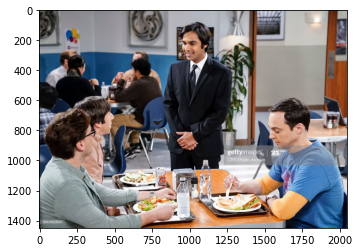

Match found: raj,7.771747589111328


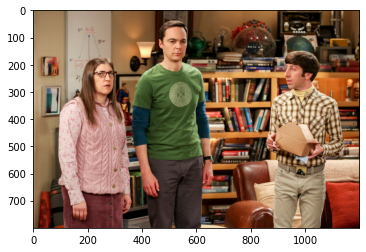

Match found: sheldon,9.189799308776855
Match found: amy,8.291741371154785


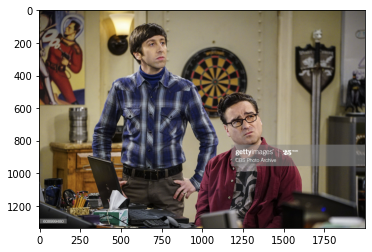

Match found: lenord,15.132299423217773
Match found: howard,9.694031715393066


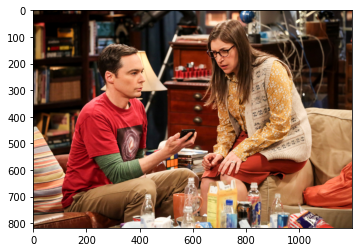

Match found: amy,10.41628646850586
Match found: raj,9.34572696685791


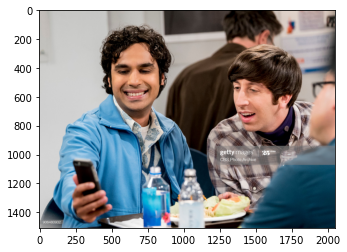

Match found: raj,8.208134651184082
Match found: howard,11.655447959899902


In [0]:
UNKNOWN_FACES_DIR = "unknown_faces"
for filename in os.listdir(UNKNOWN_FACES_DIR):
  image = face_recognition.load_image_file(f"{UNKNOWN_FACES_DIR}/{filename}")
  # image = cv2.resize(image, (640, 360))
  plt.imshow(image)
  plt.show()
  # image = cv2.resize(image, (720, 400))
  # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  locations = face_recognition.face_locations(image, model=MODEL)
  encodings = []
  # count = 123
  for top, right, bottom, left in locations:
    img = cv2.resize(np.array(image[top:bottom ,left:right]),(IMAGE_SIZE, IMAGE_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    encodings.append(convnet.predict(zscore(img)))

  for face_encoding, face_location in zip(encodings, locations):
    results = [np.sqrt(np.sum(np.square(known_faces[i]-face_encoding))) for i in range(len(known_faces))]	
    match = known_names[results.index(min(results))]
    print(f"Match found: {match},{min(results)}")
